# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

**Описание проекта**

Заказчик этого исследования — сеть отелей «Как в гостях». 


Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

**Бизнес-метрика и другие данные:**

Основная бизнес-метрика для сети отелей — прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 


В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:
 - категория A: за ночь — 1 000, разовое обслуживание — 400;
 - категория B: за ночь — 800, разовое обслуживание — 350;
 - категория C: за ночь — 600, разовое обслуживание — 350;
 - категория D: за ночь — 550, разовое обслуживание — 150;
 - категория E: за ночь — 500, разовое обслуживание — 150;
 - категория F: за ночь — 450, разовое обслуживание — 150;
 - категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

# План по выполнению проекта

1. Загрузка данных. 
2. Предобработка и исследовательский анализ данных.
3. Вычислите бизнес-метрику. Оцените прибыль отеля без внедрения депозитов.
4. Разработка модели ML.
   - Обучить разные модели и оцените их качество кросс-валидацией. Выбрать лучшую модель и проверить её на тестовой выборке. 
   - Выберать метрику для обучения.
   - Оценить прибыль, которую принесёт выбранная модель за год.
5. Выявить признаки «ненадёжного» клиента.
   - На основе исследовательского анализа данных описать клиента, склонного к отказу от брони.
6. Написать общий вывод.

# Описание данных

**Пути к файлам:**
- /datasets/hotel_train.csv — данные для обучения модели.
- /datasets/hotel_test.csv — данные для тестирования модели.

**Описание данных:**

В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:
- **id** — номер записи;
- **adults** — количество взрослых постояльцев; 
- **arrival_date_year** — год заезда;
- **arrival_date_month** — месяц заезда;
- **arrival_date_week_number** — неделя заезда;
- **arrival_date_day_of_month** — день заезда;
- **babies** — количество младенцев;
- **booking_changes** — количество изменений параметров заказа;
- **children** — количество детей от 3 до 14 лет;
- **country** — гражданство постояльца;
- **customer_type** — тип заказчика:
  - **Contract** — договор с юридическим лицом;
  - **Group** — групповой заезд;
  - **Transient** — не связано с договором или групповым заездом;
  - **Transient-party** — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- **days_in_waiting_list** — сколько дней заказ ожидал подтверждения;
- **distribution_channel** — канал дистрибуции заказа;
- **is_canceled** — отмена заказа;
- **is_repeated_guest** — признак того, что гость бронирует номер второй раз;
- **lead_time** — количество дней между датой бронирования и датой прибытия;
- **meal** — опции заказа:
  - **SC** — нет дополнительных опций;
  - **BB** — включён завтрак;
  - **FB** — включён завтрак, обед и ужин.
  - **HB** — включён завтрак и обед;
- **previous_bookings_not_canceled** — количество подтверждённых заказов у клиента;
- **previous_cancellations** — количество отменённых заказов у клиента;
- **required_car_parking_spaces** — необходимость места для автомобиля;
- **reserved_room_type** — тип забронированной комнаты;
- **stays_in_weekend_nights** — количество ночей в выходные дни;
- **stays_in_week_nights** — количество ночей в будние дни;
- **total_nights** — общее количество ночей;
- **total_of_special_requests** — количество специальных отметок.

## Загрузка данных

### Импорт библиотек

In [1]:
!pip install scikit-learn==1.3.1
!pip install imblearn

In [2]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st

import sklearn 
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,
                             mean_squared_error,
                             roc_curve, roc_auc_score,
                             f1_score,
                             accuracy_score,
                             recall_score,
                             precision_score,
                             ConfusionMatrixDisplay)

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)

import warnings
warnings.filterwarnings('ignore')

In [3]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.3.1.


### Загрузка данных

In [4]:
link1 = '/datasets/hotel_train.csv'
link2 = '/datasets/hotel_test.csv'

if os.path.exists(link1):
    hotel_train = pd.read_csv(link1)
else: print('Cсылка на hotel_train не действительна')
    
if os.path.exists(link2):
    hotel_test = pd.read_csv(link2)
else: print('Cсылка на hotel_test не действительна')

## Предобработка и исследовательский анализ данных

### Исследование данных

In [5]:
#Информация о данных:
def data_info(data, data_name):
    print('Таблица:', data_name)
    print('Размер данных:', data.shape)
    data.info()
    pd.set_option('display.max_columns', None)
    display(data.head())
    pd.set_option('display.float_format', '{:,.2f}'.format)
    #сводная статистика данных
    display(data.describe())
    print('количество дубликатов в таблице: ', data.duplicated().sum() )
    print('количество уникальных id: ', data['id'].nunique(), '\n')
    data.hist(bins=30, figsize=(15, 20))
    pass

Таблица: hotel_train
Размер данных: (65229, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-nul

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,"65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00"
mean,"43,544.07",0.37,96.34,"2,015.72",31.34,15.85,0.83,2.22,1.84,0.07,0.01,0.03,0.13,0.11,0.19,3.33,0.06,0.51,3.05
std,"25,614.86",0.48,96.13,0.45,13.46,8.75,0.85,1.35,0.48,0.33,0.10,0.16,0.97,1.33,0.59,18.24,0.23,0.75,1.74
min,0.00,0.00,0.00,"2,015.00",1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,"19,108.00",0.00,17.00,"2,015.00",21.00,8.00,0.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
50%,"40,554.00",0.00,64.00,"2,016.00",34.00,16.00,1.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00
75%,"67,414.00",1.00,151.00,"2,016.00",42.00,23.00,2.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,4.00
max,"84,121.00",1.00,374.00,"2,016.00",53.00,31.00,4.00,6.00,4.00,3.00,10.00,1.00,26.00,58.00,17.00,259.00,3.00,5.00,10.00


количество дубликатов в таблице:  0
количество уникальных id:  65229 



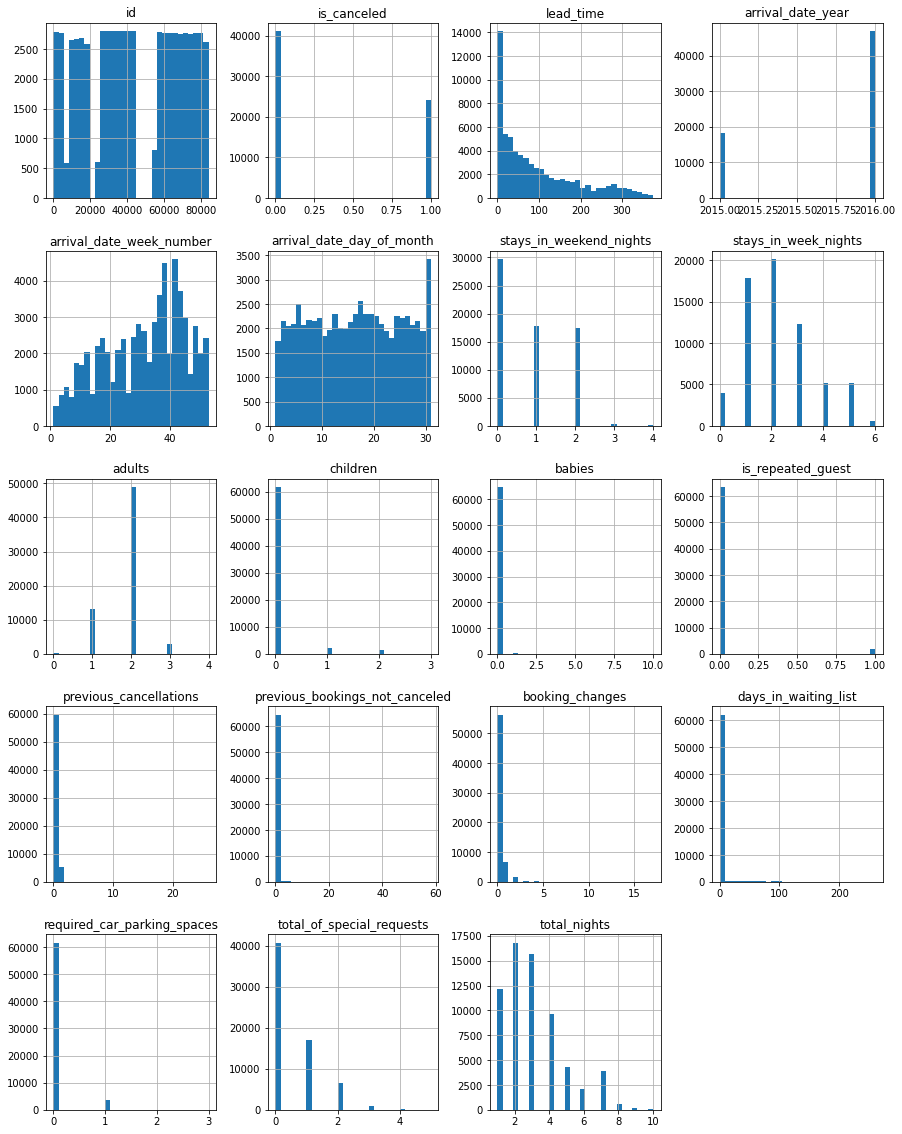

In [6]:
data_info(hotel_train, 'hotel_train')

Таблица: hotel_test
Размер данных: (32412, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.00,2017,January,1,1,1,0,2.00,0.00,0.00,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.00,2017,January,1,1,2,2,2.00,0.00,0.00,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.00,2017,January,1,1,2,2,2.00,0.00,0.00,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.00,2017,January,1,1,2,2,1.00,0.00,0.00,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.00,2017,January,1,1,2,5,2.00,0.00,0.00,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,"32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00"
mean,"60,131.51",0.39,97.59,"2,017.00",17.80,15.66,0.87,2.34,1.86,0.08,0.01,0.03,0.01,0.17,0.22,0.26,0.05,0.66,3.21
std,"29,953.59",0.49,86.51,0.00,9.18,8.77,0.85,1.38,0.49,0.34,0.08,0.17,0.18,1.88,0.64,4.73,0.22,0.83,1.74
min,"6,086.00",0.00,0.00,"2,017.00",1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,"45,291.75",0.00,23.00,"2,017.00",10.00,8.00,0.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
50%,"53,394.50",0.00,76.00,"2,017.00",18.00,15.50,1.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00
75%,"89,800.25",1.00,155.00,"2,017.00",25.00,23.00,2.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,4.00
max,"97,903.00",1.00,373.00,"2,017.00",35.00,31.00,4.00,6.00,4.00,3.00,2.00,1.00,6.00,72.00,18.00,223.00,8.00,5.00,10.00


количество дубликатов в таблице:  0
количество уникальных id:  32412 



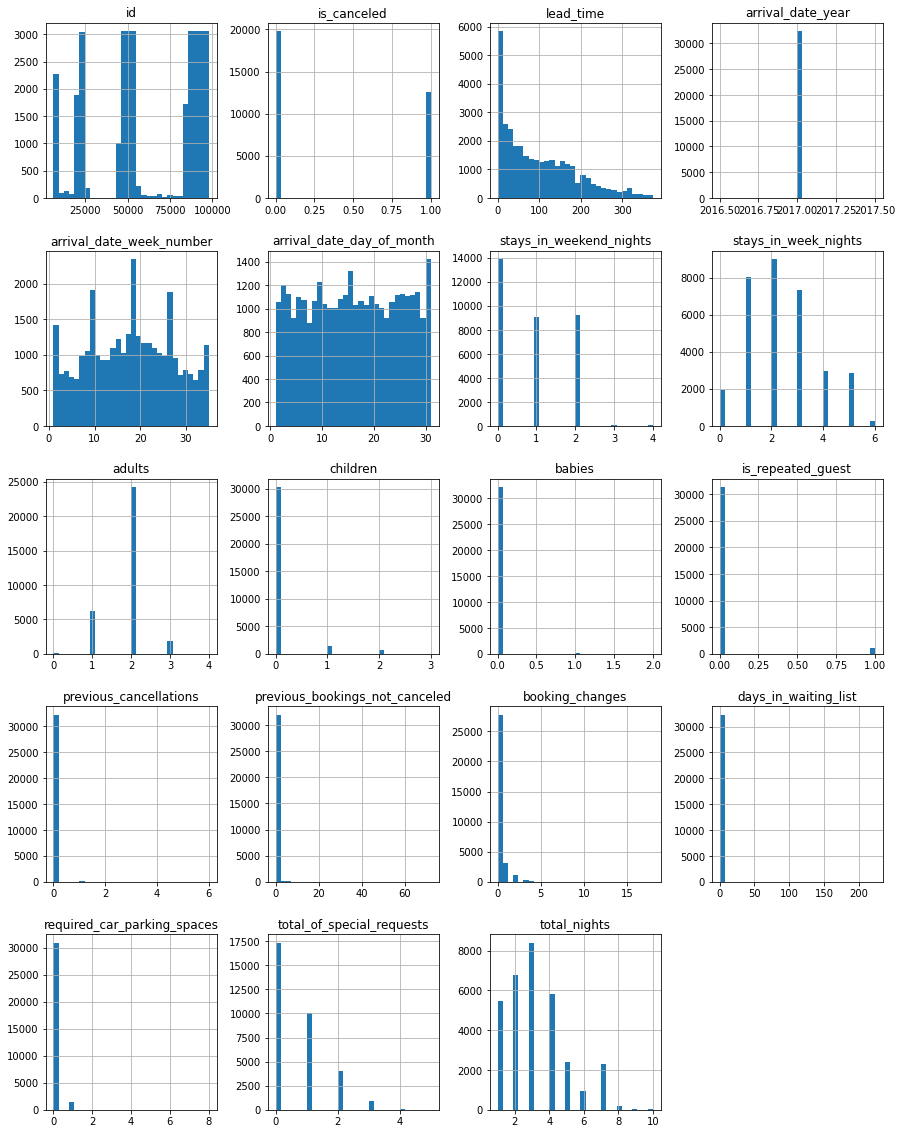

In [7]:
data_info(hotel_test, 'hotel_test')

1. Пропущенных значений в данных нет, но необходимо проверить на неявные пропуски. Дубликатов в таблиц нет. Повторяющиеся id отсутствуют. Посмотрю, будут ли дубликаты, если удалить id, думаю, повторяющиеся данные не нужны. К тому же, столбец id не несет в себе информацию для дальнейшего исследования.

2. В столбцах 'is_canceled' и 'is_repeated_guest' необходимо поменять тип данных на bool. 
3. В столбцах  'adults', 'children', 'babies' тип данных выбран неверно: вместо float должен быть integer.
4. Судя по графикам и сводным таблицам:

  - в столбце таблицы 'hotel_train' - 'arrival_date_year' (год заезда) данные за 2015 и 2016гг, в то время как в 'hotel_test' - за 2017г. 
  - в столбце таблицы 'hotel_train' - 'arrival_date_week_number' недели заездов включают данные до 52 недели, в то время как в 'hotel_test' - до 35 недели.
  - в столбце таблицы 'hotel_train' - 'babies' - количество младенцев в данных включают записи до 10 (что выглядит не очень правдоподобно, и следует проверить на аномальность), в то время как в 'hotel_test' - максимум 2.
  - в столбце таблицы 'hotel_train' - 'previous_cancellations' - количество отменённых заказов у клиента в данных включают записи и до 26, в то время как в 'hotel_test' - до 6.
  - в столбце таблицы 'hotel_train' - 'required_car_parking_spaces' - количество  необходимого места для автомобиля в данных включают записи до 8 значений, в то время как в 'hotel_test' - 0 или 1.

  
  подобная разница в данных 'hotel_train' и 'hotel_test' может привести к тому, что модель машинного обучения будет некорректно предсказывать отказ от брони. 
 
 
5. Размеры таблиц 'hotel_train' и 'hotel_test' делятся в соотношении примерно 2:1

6. **В столбце adults в двух таблицах есть значения с 0, что невозможно. Исследую этот вопрос.**

In [8]:
#Изучаю данные о бронирование без указания наличия взрослых постояльцев

def abnormal_guests(data, data_name):
    print(data_name)
    print(display(pd.DataFrame(data.query('adults == 0')[['is_canceled','children','babies']].value_counts().sort_index())))

abnormal_guests(hotel_train, 'hotel_train')
abnormal_guests(hotel_test, 'hotel_test')

hotel_train


0
is_canceled children babies    
0           0.00     0.00    15
            1.00     0.00     2
            2.00     0.00    94
                     1.00     2
            3.00     0.00     5
1           2.00     0.00    44
                     1.00     1
            3.00     0.00     3

None
hotel_test


0
is_canceled children babies    
0           0.00     0.00     7
            1.00     0.00     2
            2.00     0.00    27
            3.00     0.00     2
1           2.00     0.00    31

None


В двух таблицах есть бронирования без взрослых, некоторые из них даже с детьми. Причем, не все из этих бронирований были отменены. Так что эти строки тоже придется удалить.

In [9]:
#удаляю строки с отсутствующими взрослыми постояльцами
hotel_train.drop(columns='id', inplace=True)
hotel_train = hotel_train.query('adults != 0')
#меняю тип данных на bool
hotel_train['is_canceled'] = hotel_train['is_canceled'].astype('uint8')
hotel_train['is_repeated_guest'] = hotel_train['is_repeated_guest'].astype('uint8')
#меняю тип данных на integer
hotel_train['babies'] = hotel_train['babies'].astype(int) 
hotel_train['children'] = hotel_train['children'].astype(int) 
hotel_train['adults'] = hotel_train['adults'].astype(int)

In [10]:
#удаляю строки с отсутствующими взрослыми постояльцами
hotel_test.drop(columns='id', inplace=True)
hotel_test = hotel_test.query('adults != 0')
#меняю тип данных на bool
hotel_test['is_canceled'] = hotel_test['is_canceled'].astype('uint8')
hotel_test['is_repeated_guest'] = hotel_test['is_repeated_guest'].astype('uint8')
#меняю тип данных на integer
hotel_test['babies'] = hotel_test['babies'].astype(int) 
hotel_test['children'] = hotel_test['children'].astype(int) 
hotel_test['adults'] = hotel_test['adults'].astype(int)

In [11]:
def data_changes(data):
    
    #вывожу количество уникальных значений в столбцах
    value_uniq = ['babies', 'previous_cancellations', 'required_car_parking_spaces']
    for i in value_uniq:
        print('количество уникальных значений в столбце:',i)
        print(data[i].value_counts().sort_index(), '\n')

    #вывожу уникальные значения в столбцах
    value_uniq2 = ['country', 'customer_type', 'meal', 'distribution_channel', 'reserved_room_type']
    for i in value_uniq2:
        print('уникальные значения в столбце:',i)
        print(sorted(data[i].unique()), '\n')
    print('повторная проверка на наличие дубликатов:', data.duplicated().sum())  
    data.info()

In [12]:
data_changes(hotel_train)

количество уникальных значений в столбце: babies
0     64614
1       444
2         3
9         1
10        1
Name: babies, dtype: int64 

количество уникальных значений в столбце: previous_cancellations
0     59426
1      5366
2        54
3        51
4         5
5        13
6         7
11       35
13       12
14       11
19       17
21        1
24       28
25       19
26       18
Name: previous_cancellations, dtype: int64 

количество уникальных значений в столбце: required_car_parking_spaces
0    61383
1     3668
2       11
3        1
Name: required_car_parking_spaces, dtype: int64 

уникальные значения в столбце: country
['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATA', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR', 'BOL', 'BRA', 'BRB', 'BWA', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GGY'

In [13]:
data_changes(hotel_test)

количество уникальных значений в столбце: babies
0    32168
1      171
2        4
Name: babies, dtype: int64 

количество уникальных значений в столбце: previous_cancellations
0    32118
1      164
2       29
3        6
4       10
5        1
6       15
Name: previous_cancellations, dtype: int64 

количество уникальных значений в столбце: required_car_parking_spaces
0    30868
1     1466
2        6
3        1
8        2
Name: required_car_parking_spaces, dtype: int64 

уникальные значения в столбце: country
['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ASM', 'ATA', 'ATF', 'AUS', 'AUT', 'AZE', 'BEL', 'BEN', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BRA', 'CAF', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FRA', 'FRO', 'GAB', 'GBR', 'GHA', 'GIB', 'GNB', 'GRC', 'GTM', 'HKG', 'HRV', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN'

- При удалении id появилось много дублирующихся столбцов, удалю их.
- Удалю из 'hotel_train' значения в столбце babies с количеством детей 9 и 10, так как их всего по одному и это напоминает аномалию, возможно это приведет к тому, что модель машинного обучения будет некорректно предсказывать отказ от брони. Вариантов с детьми больше двух тоже очень мало, так что удалю и их. Тогда признак можно переименовать, например, в has_babies, чтобы обозначить его теперь уже бинарную природу. Аналогичным образом можно обработаю и признак с количеством парковочных мест
- по той же причине удалю строки в столбце required_car_parking_spaces со значением больше 2. 
- В столбце country отсутствуют очевидные неявные дубликаты.
- В столбцах customer_type и distribution_channel отсутствуют неявные дубликаты.
- В стобце meal есть неявный дубликат в опции SC, из-за лишних пробелов в данном столбце, аналогичные лишние пробелы есть и в столбце reserved_room_type. 
- Типы данных выбранных столбцов успешно изменены. 
- Судя по описанию, должна быть связь между тремя признаками: previous_cancellations, is_repeated_guest и previous_bookings_not_canceled: если клиент бронирует номер не в первый раз, то у него должны быть либо отмененные заказы, либо подтвержденные(либо и то, и другое). Если это условие не соблюдается, то все три признака могут усложнить или запутать модель, поэтому можно их упростить: например, добавить вместо них два новых бинарных признака: has_cancellations и has_successful_bookings.

In [14]:
#смотрим, есть ли данные, в которых гость не бронировал ранее номера, но есть раннее отмененные или подтвержденные брони 
def booking(data):
    booking = data[['previous_cancellations', 'is_repeated_guest', 'previous_bookings_not_canceled']]
    booking = booking.query('is_repeated_guest != 0 & previous_cancellations == 0 and previous_bookings_not_canceled == 0')
    return booking.shape

In [15]:
booking(hotel_train)

(155, 3)

In [16]:
booking(hotel_test)

(88, 3)

Достаточно много строк, в которых в которых гость не бронировал ранее номера, но есть раннее отмененные или подтвержденные брони. Чтобы исправить ситуацию, я сделаю два новых бинарных признака: has_cancellations и has_successful_bookings и удалю признак is_repeated_guest 

In [17]:
def data_changes2(data, сolumn):
    if data[сolumn] > 0:
        val = 1
    else:
        val = 0
    return val

In [18]:
hotel_train['has_cancellations'] = hotel_train.apply(data_changes2, сolumn = 'previous_cancellations', axis=1)
hotel_train['has_successful_bookings'] = hotel_train.apply(data_changes2, сolumn = 'previous_bookings_not_canceled', axis=1)

hotel_test['has_cancellations'] = hotel_test.apply(data_changes2, сolumn = 'previous_cancellations', axis=1)
hotel_test['has_successful_bookings'] = hotel_test.apply(data_changes2, сolumn = 'previous_bookings_not_canceled', axis=1)

In [19]:
hotel_train = hotel_train.query('babies < 2') #удалю строки с аномальными значениями
hotel_train = hotel_train.query('required_car_parking_spaces < 2')

hotel_train['meal'] =  hotel_train['meal'].str.replace(' ', '')
hotel_train['reserved_room_type'] =  hotel_train['reserved_room_type'].str.replace(' ', '')

hotel_train = hotel_train.rename(columns={'babies': 'has_babies', 'required_car_parking_spaces': 'has_car_parking_spaces'})

hotel_train['has_babies'] = hotel_train['has_babies'].astype('uint8')
hotel_train['has_car_parking_spaces'] = hotel_train['has_car_parking_spaces'].astype('uint8')
hotel_train['has_cancellations'] = hotel_train['has_cancellations'].astype('uint8')
hotel_train['has_successful_bookings'] = hotel_train['has_successful_bookings'].astype('uint8')

hotel_train.drop(['previous_cancellations', 'previous_bookings_not_canceled', 'is_repeated_guest'], axis= 1 , inplace= True )

hotel_train.drop_duplicates(inplace=True, ignore_index=True)
hotel_train.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,has_babies,meal,country,distribution_channel,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,has_car_parking_spaces,total_of_special_requests,total_nights,has_cancellations,has_successful_bookings
0,0,7.00,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,A,0,0,Transient,0,0,1,0,0
1,0,14.00,2015,July,27,1,0,2,2,0,0,BB,GBR,TA/TO,A,0,0,Transient,0,1,2,0,0
2,0,0.00,2015,July,27,1,0,2,2,0,0,BB,PRT,Direct,C,0,0,Transient,0,0,2,0,0
3,0,9.00,2015,July,27,1,0,2,2,0,0,FB,PRT,Direct,C,0,0,Transient,0,1,2,0,0
4,1,85.00,2015,July,27,1,0,3,2,0,0,BB,PRT,TA/TO,A,0,0,Transient,0,1,3,0,0


In [20]:
hotel_test = hotel_test.query('babies < 2') #удалю строки с аномальными значениями
hotel_test = hotel_test.query('required_car_parking_spaces < 2')

hotel_test['meal'] =  hotel_test['meal'].str.replace(' ', '')
hotel_test['reserved_room_type'] =  hotel_test['reserved_room_type'].str.replace(' ', '')

hotel_test = hotel_test.rename(columns={'babies': 'has_babies', 'required_car_parking_spaces': 'has_car_parking_spaces'})

hotel_test['has_babies'] = hotel_test['has_babies'].astype('uint8')
hotel_test['has_car_parking_spaces'] = hotel_test['has_car_parking_spaces'].astype('uint8')
hotel_test['has_cancellations'] = hotel_test['has_cancellations'].astype('uint8')
hotel_test['has_successful_bookings'] = hotel_test['has_successful_bookings'].astype('uint8')

hotel_test.drop(['previous_cancellations', 'previous_bookings_not_canceled', 'is_repeated_guest'], axis= 1 , inplace= True )

hotel_test.drop_duplicates(inplace=True, ignore_index=True)
hotel_test.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,has_babies,meal,country,distribution_channel,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,has_car_parking_spaces,total_of_special_requests,total_nights,has_cancellations,has_successful_bookings
0,1,74.00,2017,January,1,1,1,0,2,0,0,BB,PRT,TA/TO,A,0,0,Transient,0,0,1,0,0
1,1,62.00,2017,January,1,1,2,2,2,0,0,BB,AUT,TA/TO,A,0,0,Transient,0,1,4,0,0
2,1,71.00,2017,January,1,1,2,2,1,0,0,BB,PRT,TA/TO,A,0,0,Transient,0,1,4,0,0
3,1,172.00,2017,January,1,1,2,5,2,0,0,BB,BEL,TA/TO,A,0,0,Transient,0,0,7,0,0
4,1,52.00,2017,January,1,1,2,5,1,0,0,BB,DEU,TA/TO,A,0,0,Transient,0,0,7,0,0


**Проверка на мультиколлинеарность признаков**

Ситуация мультиколлинеарности возникает, когда две независимые переменные имеют сильную корреляцию.

Поскольку существует сильная взаимосвязь, определение значимых переменных будет сложной задачей. Может произойти переобучение, и точность модели изменится в зависимости от набора данных.

In [21]:
def correlations(x1, data_name, thresh):
    print(data_name)
    upp_mat = np.triu(x1.corr())
    fig, ax = plt.subplots(figsize=(15, 5))

    sns.heatmap(x1.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat)
    plt.title('Тепловая карта корреляций признаков')
    
    plt.show()

hotel_train:


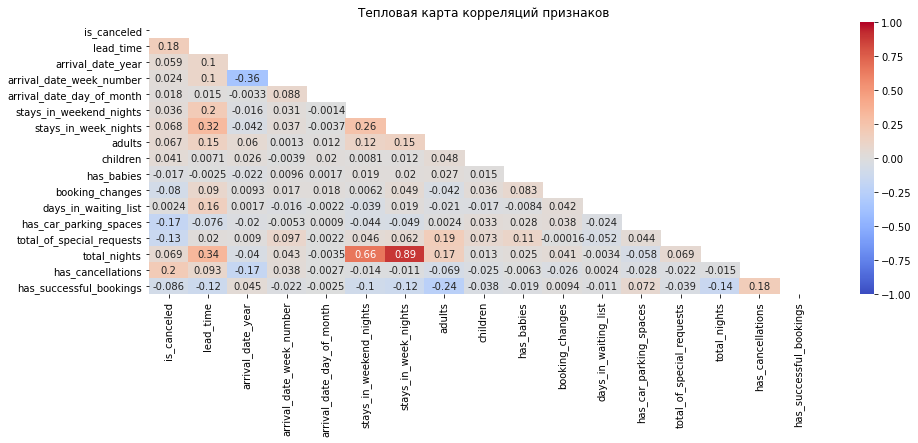

hotel_test:


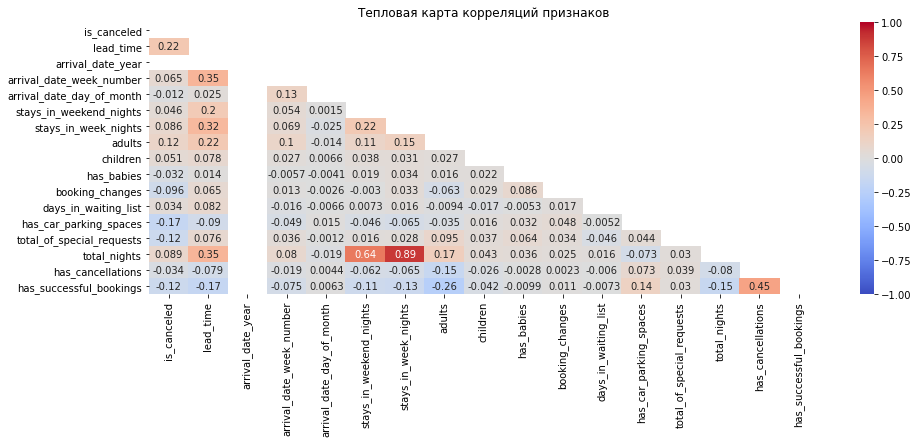

In [22]:
correlations(hotel_train, 'hotel_train:', 0.5)
correlations(hotel_test, 'hotel_test:', 0.5)

По тепловой карте видно, что есть сильно коррелирующие признаки

In [23]:
#функция для вывода коррелирующих признаков для выбранного порога
def correl(x_train, thresh):
    cor = x_train.corr()
    c1 = cor.stack().sort_values(ascending=False).drop_duplicates()
    all_cor = c1[c1.values != 1]
    return all_cor[abs(all_cor) > thresh]

In [24]:
correl(hotel_train, 0.5)

total_nights             stays_in_week_nights   0.89
stays_in_weekend_nights  total_nights           0.66
dtype: float64

In [25]:
correl(hotel_test, 0.5)

total_nights             stays_in_week_nights   0.89
stays_in_weekend_nights  total_nights           0.64
dtype: float64

Корреляция признаков total_nights - stays_in_week_nights и total_nights - stays_in_weekend_nights довольно логично. 
Признак total_nights - ключевой. Удалю стобцы stays_in_week_nights и stays_in_weekend_nights. Судя по описанию, total_nights — это stays_in_week_nights и stays_in_weekend_nights, но тогда перед удалением правильнее будет проверить, что это условие выполняется для всех бронирований

In [26]:
def nights(data):
    nights = data[['stays_in_week_nights', 'stays_in_weekend_nights', 'total_nights']]
    nights = nights.query('stays_in_week_nights + stays_in_weekend_nights != total_nights')
    return nights.shape

In [27]:
nights(hotel_train)

(0, 3)

In [28]:
nights(hotel_test)

(0, 3)

условие выполняется для всех бронирований

In [29]:
hotel_train.drop(columns='stays_in_weekend_nights', inplace=True)
hotel_train.drop(columns='stays_in_week_nights', inplace=True)

hotel_test.drop(columns='stays_in_weekend_nights', inplace=True)
hotel_test.drop(columns='stays_in_week_nights', inplace=True)

In [30]:
hotel_train.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month', 'adults',
       'children', 'has_babies', 'meal', 'country', 'distribution_channel',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'has_car_parking_spaces', 'total_of_special_requests',
       'total_nights', 'has_cancellations', 'has_successful_bookings'],
      dtype='object')

- Номер недели всегда будет линейно зависим с номером месяца, поэтому номер недели удалю.
- Год заезда не пригодится, так как модели не придется делать предсказания для прошлых лет.
- День заезда, вероятнее, только внесет шум в данные, такая точность здесь ни к чему.

In [31]:
hotel_train.drop(columns='arrival_date_week_number', inplace=True)
hotel_train.drop(columns='arrival_date_year', inplace=True)
hotel_train.drop(columns='arrival_date_day_of_month', inplace=True)

hotel_test.drop(columns='arrival_date_week_number', inplace=True)
hotel_test.drop(columns='arrival_date_year', inplace=True)
hotel_test.drop(columns='arrival_date_day_of_month', inplace=True)

hotel_train.drop_duplicates(inplace=True, ignore_index=True)
hotel_test.drop_duplicates(inplace=True, ignore_index=True)

In [32]:
#проверка
def check(data):
    data.info()
    print(data['meal'].unique(),data['reserved_room_type'].unique())
    display(data.head(3))
    print(data.shape[0])
    
check(hotel_train)
check(hotel_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42369 entries, 0 to 42368
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   is_canceled                42369 non-null  uint8  
 1   lead_time                  42369 non-null  float64
 2   arrival_date_month         42369 non-null  object 
 3   adults                     42369 non-null  int64  
 4   children                   42369 non-null  int64  
 5   has_babies                 42369 non-null  uint8  
 6   meal                       42369 non-null  object 
 7   country                    42369 non-null  object 
 8   distribution_channel       42369 non-null  object 
 9   reserved_room_type         42369 non-null  object 
 10  booking_changes            42369 non-null  int64  
 11  days_in_waiting_list       42369 non-null  int64  
 12  customer_type              42369 non-null  object 
 13  has_car_parking_spaces     42369 non-null  uin

,is_canceled,lead_time,arrival_date_month,adults,children,has_babies,meal,country,distribution_channel,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,has_car_parking_spaces,total_of_special_requests,total_nights,has_cancellations,has_successful_bookings
0,0,7.00,July,1,0,0,BB,GBR,Direct,A,0,0,Transient,0,0,1,0,0
1,0,14.00,July,2,0,0,BB,GBR,TA/TO,A,0,0,Transient,0,1,2,0,0
2,0,0.00,July,2,0,0,BB,PRT,Direct,C,0,0,Transient,0,0,2,0,0


42369
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24250 entries, 0 to 24249
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   is_canceled                24250 non-null  uint8  
 1   lead_time                  24250 non-null  float64
 2   arrival_date_month         24250 non-null  object 
 3   adults                     24250 non-null  int64  
 4   children                   24250 non-null  int64  
 5   has_babies                 24250 non-null  uint8  
 6   meal                       24250 non-null  object 
 7   country                    24250 non-null  object 
 8   distribution_channel       24250 non-null  object 
 9   reserved_room_type         24250 non-null  object 
 10  booking_changes            24250 non-null  int64  
 11  days_in_waiting_list       24250 non-null  int64  
 12  customer_type              24250 non-null  object 
 13  has_car_parking_spaces     24250 non-nul

,is_canceled,lead_time,arrival_date_month,adults,children,has_babies,meal,country,distribution_channel,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,has_car_parking_spaces,total_of_special_requests,total_nights,has_cancellations,has_successful_bookings
0,1,74.00,January,2,0,0,BB,PRT,TA/TO,A,0,0,Transient,0,0,1,0,0
1,1,62.00,January,2,0,0,BB,AUT,TA/TO,A,0,0,Transient,0,1,4,0,0
2,1,71.00,January,1,0,0,BB,PRT,TA/TO,A,0,0,Transient,0,1,4,0,0


24250


**Исследование целевого признака**

In [33]:
def create_pie(target_column, data_name):
    plt.pie(target_column.value_counts(), 
        labels=target_column.value_counts().index, 
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white'}, 
        autopct='%.1f%%',
        
       )
    plt.title(f'Исследование целевого признака таблицы {data_name}')
    plt.show()

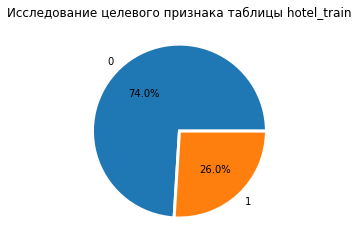

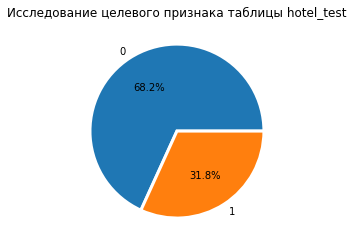

In [34]:
create_pie(hotel_train['is_canceled'], 'hotel_train')
create_pie(hotel_test['is_canceled'], 'hotel_test')

Целевой признак несбалансирован. В таблице hotel_train процент отказа от брони составляет 25.4%, в hotel_test - 31.5%.
В дальнейшем будет применена балансировка классов, хоть дисбаланс и не критичный. 

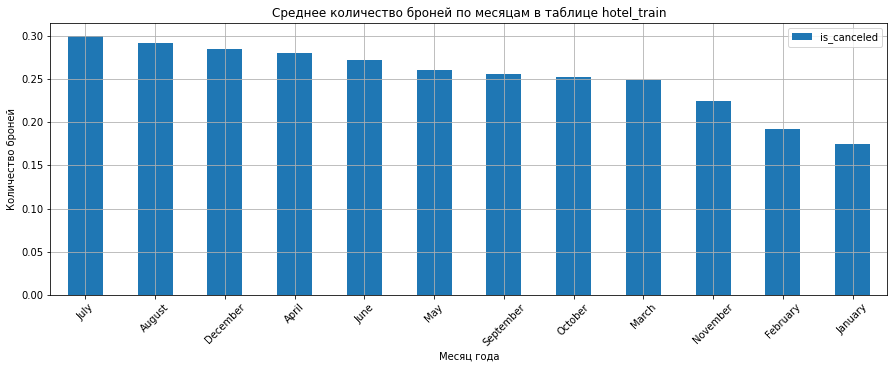

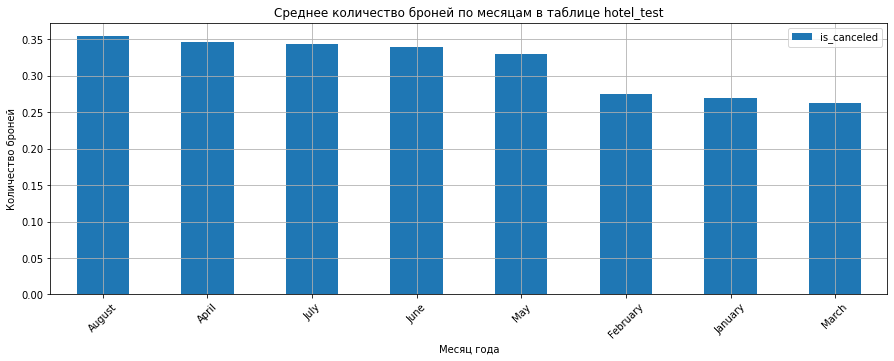

In [35]:
hotel_train.groupby('arrival_date_month').agg('mean').sort_values(by='is_canceled',ascending=False).plot(title='Cреднее количество броней по месяцам в таблице hotel_train',kind='bar',figsize=(15,5),stacked=True,
                  y='is_canceled')
plt.xlabel('Месяц года')
plt.ylabel('Количество броней')
plt.grid()
plt.xticks(rotation=45)
plt.show()

hotel_test.groupby('arrival_date_month').agg('mean').sort_values(by='is_canceled',ascending=False).plot(title='Cреднее количество броней по месяцам в таблице hotel_test',kind='bar',figsize=(15,5),stacked=True,
                  y='is_canceled')
plt.xlabel('Месяц года')
plt.ylabel('Количество броней')
plt.grid()
plt.xticks(rotation=45)
plt.show()

В основном, бронирование номеров происходит летом, дальше идут весенние и осенние месяцы, традиционный спад в январе из-за новогодних праздников. Ценовая политика отеля с использованием сезонных коэффициенты (весной и осенью цены повышаются на 20%, летом — на 40%) - рациональна. 

### Объявление переменных

Объявление четырех переменных:
- признаки: x_train, x_test;
- целевой признак: y_train, y_test.

In [36]:
hotel_train.columns

Index(['is_canceled', 'lead_time', 'arrival_date_month', 'adults', 'children',
       'has_babies', 'meal', 'country', 'distribution_channel',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'has_car_parking_spaces', 'total_of_special_requests',
       'total_nights', 'has_cancellations', 'has_successful_bookings'],
      dtype='object')

In [37]:
features = ['lead_time', 'arrival_date_month',
            'adults', 'children','has_babies', 'meal', 'country',
            'distribution_channel','reserved_room_type', 'booking_changes',
            'days_in_waiting_list','customer_type', 'has_car_parking_spaces',
            'total_of_special_requests','total_nights', 'has_cancellations',
            'has_successful_bookings'
           ]
target = 'is_canceled'

x_train = hotel_train[features]
y_train = hotel_train[target]

x_test = hotel_test[features]
y_test = hotel_test[target]

display(x_train.head(), x_test.head())

,lead_time,arrival_date_month,adults,children,has_babies,meal,country,distribution_channel,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,has_car_parking_spaces,total_of_special_requests,total_nights,has_cancellations,has_successful_bookings
0,7.00,July,1,0,0,BB,GBR,Direct,A,0,0,Transient,0,0,1,0,0
1,14.00,July,2,0,0,BB,GBR,TA/TO,A,0,0,Transient,0,1,2,0,0
2,0.00,July,2,0,0,BB,PRT,Direct,C,0,0,Transient,0,0,2,0,0
3,9.00,July,2,0,0,FB,PRT,Direct,C,0,0,Transient,0,1,2,0,0
4,85.00,July,2,0,0,BB,PRT,TA/TO,A,0,0,Transient,0,1,3,0,0


,lead_time,arrival_date_month,adults,children,has_babies,meal,country,distribution_channel,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,has_car_parking_spaces,total_of_special_requests,total_nights,has_cancellations,has_successful_bookings
0,74.00,January,2,0,0,BB,PRT,TA/TO,A,0,0,Transient,0,0,1,0,0
1,62.00,January,2,0,0,BB,AUT,TA/TO,A,0,0,Transient,0,1,4,0,0
2,71.00,January,1,0,0,BB,PRT,TA/TO,A,0,0,Transient,0,1,4,0,0
3,172.00,January,2,0,0,BB,BEL,TA/TO,A,0,0,Transient,0,0,7,0,0
4,52.00,January,1,0,0,BB,DEU,TA/TO,A,0,0,Transient,0,0,7,0,0


### Кодирование категориальных и численных признаков

Будут использованы OHE кодирование категориальных признаков и StandardScaler для численных признаков.

In [38]:
#категориальные признаки для OHE 
ohe_features = x_train.select_dtypes(include='object').columns.to_list()
print(ohe_features)

['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']


In [39]:
#численные признаки

#'has_babies' — категориальный бинарный признак
#'has_car_parking_spaces' — категориальный бинарный признак
#'has_cancellations' — категориальный бинарный признак
#'has_successful_bookings' — категориальный бинарный признак

num_features = x_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('has_babies')
num_features.remove('has_car_parking_spaces')
num_features.remove('has_cancellations')
num_features.remove('has_successful_bookings')

num_features

['lead_time',
 'adults',
 'children',
 'booking_changes',
 'days_in_waiting_list',
 'total_of_special_requests',
 'total_nights']

**Масштабирование**

In [40]:
x_train = x_train.copy()
x_test = x_test.copy()

In [41]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(x_train[ohe_features])

# добавляем закодированные признаки в x_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
x_train[encoder_ohe.get_feature_names_out()
             ] = encoder_ohe.transform(x_train[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
x_train = x_train.drop(ohe_features, axis=1)

# стандартизация данных
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
x_train[num_features] = scaler.fit_transform(x_train[num_features])

# проверка
x_train.head()

,lead_time,adults,children,has_babies,booking_changes,days_in_waiting_list,has_car_parking_spaces,total_of_special_requests,total_nights,has_cancellations,has_successful_bookings,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ATA,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FRA,country_GAB,country_GBR,country_GEO,country_GGY,country_GIB,country_GLP,country_GNB,country_GRC,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KNA,country_KOR,country_KWT,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MUS,country_MWI,country_MYS,country_NAM,country_NGA,country_NIC,country_NLD,country_NOR,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SEN,country_SGP,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,-0.84,-1.78,-0.27,0,-0.37,-0.08,0,-0.85,-1.21,0,0,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,-0.75,0.26,-0.27,0,-0.37,-0.08,0,0.39,-0.67,0,0,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00

In [42]:
x_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(x_test[ohe_features])

x_test = x_test.drop(ohe_features, axis=1)

# масштабируем тестовую
x_test[num_features] = scaler.transform(x_test[num_features])

# проверка
x_test.head()

,lead_time,adults,children,has_babies,booking_changes,days_in_waiting_list,has_car_parking_spaces,total_of_special_requests,total_nights,has_cancellations,has_successful_bookings,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ATA,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FRA,country_GAB,country_GBR,country_GEO,country_GGY,country_GIB,country_GLP,country_GNB,country_GRC,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KNA,country_KOR,country_KWT,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MUS,country_MWI,country_MYS,country_NAM,country_NGA,country_NIC,country_NLD,country_NOR,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SEN,country_SGP,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0.06,0.26,-0.27,0,-0.37,-0.08,0,-0.85,-1.21,0,0,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,-0.10,0.26,-0.27,0,-0.37,-0.08,0,0.39,0.40,0,0,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.

In [43]:
#заменяю строчные буквы на прописные
x_test.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in x_test.columns] 
x_train.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in x_train.columns]

In [44]:
x_train.shape, x_test.shape

((42369, 191), (24250, 191))

одинаковое количество признаков

In [45]:
(x_train.columns != x_test.columns).sum()

0

одинаковые признаки в тренировочной и тестовой выборках

### Вывод по обработке и анализу данных

1. Пропущенных значений в данных нет. Дубликатов в таблиц нет. 

2. В столбцах 'is_canceled' и 'is_repeated_guest' изменен тип данных на bool. 
3. В столбцах  'adults', 'children', 'babies' тип данных выбран неверно: вместо float изменен на integer.
4. Судя по графикам и сводным таблицам:

  - в столбце таблицы 'hotel_train' - 'arrival_date_year' (год заезда) данные за 2015 и 2016гг, в то время как в 'hotel_test' - за 2017г. 
  - в столбце таблицы 'hotel_train' - 'arrival_date_week_number' недели заездов включают данные до 52 недели, в то время как в 'hotel_test' - до 35 недели.
  - в столбце таблицы 'hotel_train' - 'babies' - количество младенцев в данных включают записи до 10 (что выглядит не очень правдоподобно, и следует проверить на аномальность), в то время как в 'hotel_test' - максимум 2.
  - в столбце таблицы 'hotel_train' - 'previous_cancellations' - количество отменённых заказов у клиента в данных включают записи и до 26, в то время как в 'hotel_test' - до 6.
  - в столбце таблицы 'hotel_train' - 'required_car_parking_spaces' - количество  необходимого места для автомобиля в данных включают записи до 8 значений, в то время как в 'hotel_test' - 0 или 1.

  
  подобная разница в данных 'hotel_train' и 'hotel_test' может привести к тому, что модель машинного обучения будет некорректно предсказывать отказ от брони. 
 
 
5. Размеры таблиц 'hotel_train' и 'hotel_test' делятся в соотношении примерно 2:1

6. В двух таблицах есть бронирования без взрослых, некоторые из них даже с детьми. Причем, не все из этих бронирований были отменены. Так что эти строки были удалены.

7. 
- При удалении id появилось много дублирующихся столбцов, удалены.
- Удалены из 'hotel_train' значения в столбце babies с количеством детей 9 и 10, так как их всего по одному и это напоминает аномалию, возможно это приведет к тому, что модель машинного обучения будет некорректно предсказывать отказ от брони. Вариантов с детьми больше двух тоже очень мало, так что удалены и они. Признак переименован в has_babies, чтобы обозначить его теперь уже бинарную природу. Аналогичным образом обработан и признак с количеством парковочных мест
- по той же причине удалены строки в столбце required_car_parking_spaces со значением больше 2. 
- В стобце meal есть неявный дубликат в опции SC, из-за лишних пробелов в данном столбце, аналогичные лишние пробелы есть и в столбце reserved_room_type. 
- Типы данных выбранных столбцов успешно изменены. 
- Судя по описанию, должна быть связь между тремя признаками: previous_cancellations, is_repeated_guest и previous_bookings_not_canceled: если клиент бронирует номер не в первый раз, то у него должны быть либо отмененные заказы, либо подтвержденные. Эти условия не соблюдаются, все три признака могут усложнить или запутать модель, поэтому добавлены вместо них два новых бинарных признака: has_cancellations и has_successful_bookings.

9. Использовалось OHE кодирование категориальных признаков и StandardScaler для численных признаков для будущих моделей.

11. Целевой признак несбалансирован. В таблице hotel_train процент отказа от брони составляет 25.4%, в hotel_test - 31.5%. В дальнейшем будет применена балансировка классов. 

12. В основном, бронирование номеров происходит летом, дальше идут весенние и осенние месяцы, традиционный спад в январе из-за новогодних праздников. Ценовая политика отеля с использованием сезонных коэффициенты (весной и осенью цены повышаются на 20%, летом — на 40%) - рациональна.

## Формулировка ML-задачи на основе бизнес-задачи

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 


Стоимость номеров отеля:


- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.


В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

Основные бизнес-метрики:
 - столбец 'is_canceled' - факт отмены брони 
 - столбец 'arrival_date_month' - месяц заезда
 - столбец 'reserved_room_typ' - тип забронированной комнаты 
 - столбец 'total_nights' -  общее количество ночей

In [46]:
income_data = hotel_test[['is_canceled', 'arrival_date_month', 'reserved_room_type', 'total_nights']]
income_data.head()

,is_canceled,arrival_date_month,reserved_room_type,total_nights
0,1,January,A,1
1,1,January,A,4
2,1,January,A,4
3,1,January,A,7
4,1,January,A,7


In [47]:
#добавлю столбцы, объединяя таблицы по ключевым признакам
month = pd.DataFrame({'arrival_date_month' : [i for i in income_data['arrival_date_month'].unique()],
                      'factor' : [1, 1, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4]})

income_data = income_data.merge(month, on='arrival_date_month', how='left')

room_type_price = pd.DataFrame({'reserved_room_type' : [i for i in sorted(income_data['reserved_room_type'].unique())],
                                'night_price' : [1000, 800, 600, 550, 500, 450, 350],
                                'service_price' : [400, 350, 350, 150, 150, 150, 150]
                               })

income_data = income_data.merge(room_type_price, on='reserved_room_type', how='left')
income_data.head()

,is_canceled,arrival_date_month,reserved_room_type,total_nights,factor,night_price,service_price
0,1,January,A,1,1.00,1000,400
1,1,January,A,4,1.00,1000,400
2,1,January,A,4,1.00,1000,400
3,1,January,A,7,1.00,1000,400
4,1,January,A,7,1.00,1000,400


**Расчет прибыли**

In [48]:
#функция для расчета прибыли
def profit(data):
    if data['is_canceled'] == 0:
        income = data['night_price'] * data['factor'] * data['total_nights']
        spenses = data['service_price'] * (1 + data['total_nights'] // 2)
    else:
        income = 0
        spenses = data['service_price'] + (data['night_price'] * data['factor'])
    profit = income - spenses
    return profit

In [49]:
income_data['total_profit'] = income_data.apply(profit, axis=1)

In [50]:
display(income_data.head())
total_profit_sum = round(income_data['total_profit'].sum()/1000000,2)
print('Прибыль с января по август 2017 г. без внедрения депозита:', total_profit_sum, 'млн.руб.')

,is_canceled,arrival_date_month,reserved_room_type,total_nights,factor,night_price,service_price,total_profit
0,1,January,A,1,1.00,1000,400,"-1,400.00"
1,1,January,A,4,1.00,1000,400,"-1,400.00"
2,1,January,A,4,1.00,1000,400,"-1,400.00"
3,1,January,A,7,1.00,1000,400,"-1,400.00"
4,1,January,A,7,1.00,1000,400,"-1,400.00"


Прибыль с января по август 2017 г. без внедрения депозита: 32.29 млн.руб.


### Вывод

1. Создана таблица с ключевыми бизнес-метриками
2. Разработана функция для расчета прибыли отеля
3. Прибыль с января по август 2017 г. без внедрения депозита составила 32.6 млн.руб.

## Разработка модели ML

Для проекта выбраны три модели машинного обучения:

- **DecisionTreeClassifier** - это семейство моделей машинного обучения. Решающее дерево предсказывает значение целевой переменной с помощью применения последовательности простых решающих правил
- **RandomForestClassifier** - это алгоритм машинного обучения, который используется для решения задач классификации и регрессии.
- **LogisticRegression** — это алгоритм классификации в машинном обучении для прогнозирования вероятности категориально зависимой переменной.

Также будут использованы две техникии балансировки классов undersampling и oversampling:

- Недостаточная выборка с использованием Tomek links (undersampling): обнаруживает и удаляет выборки из Tomek links.
- Oversampling с использованием SMOTE: синтезируйте новые выборки на основе класса меньшинства.
- SMOTETomek - Комбинация over- and under-sampling с использованием одновременно SMOTE и Tomek links.

Выбор модели будет происходить по оценки f1.

f1 сохраняет баланс между Precision и Recall. Хорошо подходит при неравномерном распределении классов, так как точность и запоминание могут привести к ошибочным результатам.

Таким образом, мы используем оценку F1 в качестве показателя сравнения между показателями Precision и Recall.

### Модели без балансировки классов

In [51]:
#таблица для сравнения моделей
result = pd.DataFrame(index=['decision_tree_cl','random_forest_cl', 'log_reg'],columns=['data', 'tomek_data', 'smote_tomek_data'])
result

,data,tomek_data,smote_tomek_data
decision_tree_cl,NaN,NaN,NaN
random_forest_cl,NaN,NaN,NaN
log_reg,NaN,NaN,NaN


In [52]:
x_train.head()

,lead_time,adults,children,has_babies,booking_changes,days_in_waiting_list,has_car_parking_spaces,total_of_special_requests,total_nights,has_cancellations,has_successful_bookings,arrival_date_month__august,arrival_date_month__december,arrival_date_month__february,arrival_date_month__january,arrival_date_month__july,arrival_date_month__june,arrival_date_month__march,arrival_date_month__may,arrival_date_month__november,arrival_date_month__october,arrival_date_month__september,meal__f_b,meal__h_b,meal__s_c,country__a_g_o,country__a_l_b,country__a_n_d,country__a_r_e,country__a_r_g,country__a_r_m,country__a_t_a,country__a_u_s,country__a_u_t,country__a_z_e,country__b_d_i,country__b_e_l,country__b_e_n,country__b_f_a,country__b_g_d,country__b_g_r,country__b_h_r,country__b_i_h,country__b_l_r,country__b_o_l,country__b_r_a,country__b_r_b,country__b_w_a,country__c_h_e,country__c_h_l,country__c_h_n,country__c_i_v,country__c_m_r,country__c_n,country__c_o_l,country__c_p_v,country__c_r_i,country__c_u_b,country__c_y_m,country__c_y_p,country__c_z_e,country__d_e_u,country__d_m_a,country__d_n_k,country__d_o_m,country__d_z_a,country__e_c_u,country__e_g_y,country__e_s_p,country__e_s_t,country__e_t_h,country__f_i_n,country__f_r_a,country__g_a_b,country__g_b_r,country__g_e_o,country__g_g_y,country__g_i_b,country__g_l_p,country__g_n_b,country__g_r_c,country__g_u_y,country__h_k_g,country__h_n_d,country__h_r_v,country__h_u_n,country__i_d_n,country__i_m_n,country__i_n_d,country__i_r_l,country__i_r_n,country__i_r_q,country__i_s_l,country__i_s_r,country__i_t_a,country__j_a_m,country__j_e_y,country__j_o_r,country__j_p_n,country__k_a_z,country__k_e_n,country__k_h_m,country__k_n_a,country__k_o_r,country__k_w_t,country__l_b_n,country__l_b_y,country__l_c_a,country__l_i_e,country__l_k_a,country__l_t_u,country__l_u_x,country__l_v_a,country__m_a_c,country__m_a_r,country__m_c_o,country__m_d_v,country__m_e_x,country__m_k_d,country__m_l_i,country__m_l_t,country__m_m_r,country__m_n_e,country__m_o_z,country__m_u_s,country__m_w_i,country__m_y_s,country__n_a_m,country__n_g_a,country__n_i_c,country__n_l_d,country__n_o_r,country__n_z_l,country__o_m_n,country__p_a_k,country__p_a_n,country__p_e_r,country__p_h_l,country__p_l_w,country__p_o_l,country__p_r_i,country__p_r_t,country__p_r_y,country__p_y_f,country__q_a_t,country__r_o_u,country__r_u_s,country__r_w_a,country__s_a_u,country__s_e_n,country__s_g_p,country__s_l_v,country__s_m_r,country__s_r_b,country__s_t_p,country__s_u_r,country__s_v_k,country__s_v_n,country__s_w_e,country__s_y_c,country__s_y_r,country__t_h_a,country__t_j_k,country__t_m_p,country__t_u_n,country__t_u_r,country__t_w_n,country__t_z_a,country__u_g_a,country__u_k_r,country__u_r_y,country__u_s_a,country__u_z_b,country__v_e_n,country__v_g_b,country__v_n_m,country__z_a_f,country__z_m_b,country__z_w_e,distribution_channel__direct,distribution_channel__g_d_s,distribution_channel__t_a/_t_o,reserved_room_type__b,reserved_room_type__c,reserved_room_type__d,reserved_room_type__e,reserved_room_type__f,reserved_room_type__g,customer_type__group,customer_type__transient,customer_type__transient-_party
0,-0.84,-1.78,-0.27,0,-0.37,-0.08,0,-0.85,-1.21,0,0,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0

**DecisionTreeClassifier**

```
dec_tree = DecisionTreeClassifier(random_state=12345)

params =  {'criterion':['gini', 'entropy'],
           'max_depth': range(1,21),
           'max_features': ['auto', 'sqrt', 'log2',  None],
           'splitter':['best', 'random'],
           'class_weight': ['balanced', None]}

grid = RandomizedSearchCV(dec_tree,
                         params,
                         cv=5,
                         n_iter=500,
                         n_jobs=-1,
                         scoring='f1',
                         random_state=12345)


grid.fit(x_train, y_train)

grid.best_score = grid.best_score_
grid.best_score_, grid.best_params_
```

Вывод: f1 = 0.51,
-  'splitter': 'best',
-  'max_features': None,
-  'max_depth': 6,
-  'class_weight': 'balanced'

In [53]:
result.loc['decision_tree_cl','data'] = 0.51
result

,data,tomek_data,smote_tomek_data
decision_tree_cl,0.51,NaN,NaN
random_forest_cl,NaN,NaN,NaN
log_reg,NaN,NaN,NaN


**RandomForestClassifier**

```
rand_forest = RandomForestClassifier(random_state=12345)

params =  {'max_depth': range(1,21),
           'n_estimators': (50, 251, 50),
           'class_weight':['balanced', 'balanced_subsample', None]}

grid = RandomizedSearchCV(rand_forest,
                          params,
                          cv=5,
                          n_iter=250,
                          n_jobs=-1,
                          scoring='f1',
                          random_state=12345)

grid.fit(x_train, y_train)

grid.best_score = grid.best_score_
grid.best_score_, grid.best_params_
```

Вывод: f1 = 0.45,
- 'n_estimators': 251,
- 'max_depth': 2,
- 'class_weight': 'balanced_subsample'

In [54]:
result.loc['random_forest_cl','data'] = 0.45
result

,data,tomek_data,smote_tomek_data
decision_tree_cl,0.51,NaN,NaN
random_forest_cl,0.45,NaN,NaN
log_reg,NaN,NaN,NaN


**LogisticRegression**

```
log_regress = LogisticRegression(random_state=12345)

params =  {                                       
           'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
           'class_weight':['balanced', None]}


grid = RandomizedSearchCV(log_regress,
                          params,
                          cv=5,
                          n_iter=100,
                          n_jobs=-1,
                          scoring='f1',
                          random_state=12345)

grid.fit(x_train, y_train)

grid.best_score = grid.best_score_
grid.best_score_, grid.best_params_
```

Вывод: f1 = 0.43,
- 'class_weight': 'balanced'
- 'C': 0.001

In [55]:
result.loc['log_reg','data'] = 0.43
result

,data,tomek_data,smote_tomek_data
decision_tree_cl,0.51,NaN,NaN
random_forest_cl,0.45,NaN,NaN
log_reg,0.43,NaN,NaN


### Tomek Links

Один из предоставляемых методов называется «Tomek Links». «Links» в данном случае — пары элементов из разных классов, находящиеся поблизости.


Используя алгоритм мы в конечном итоге удалим элемент пары из большего набора, что позволит классификатору отработать лучше.

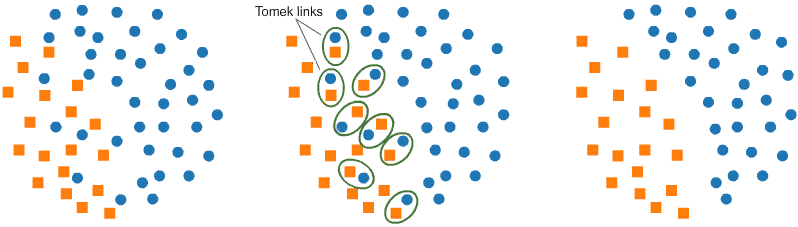

In [56]:
tl = TomekLinks()
X_tl, y_tl = tl.fit_resample(x_train, y_train) 

In [57]:
print('Дисбаланс классов y_tl:', round(y_tl[y_tl==0].count()/y_tl[y_tl==1].count(),0))

Дисбаланс классов y_tl: 3.0


По умолчанию при недостаточной выборке Tomek links удаляется только тот класс большинства, который близок к классу меньшинства. Таким образом, данные остаются несбалансированными.

**DecisionTreeClassifier**

```
dec_tree = DecisionTreeClassifier(random_state=12345)

params =  {'criterion':['gini', 'entropy'],
           'max_depth': range(1,21),
           'max_features': ['auto', 'sqrt', 'log2',  None],
           'splitter':['best', 'random'],
           'class_weight': ['balanced', None]
          }

grid = RandomizedSearchCV(dec_tree,
                          params,
                          cv=5,
                          n_iter=500,
                          n_jobs=-1,
                          scoring='f1',
                          random_state=12345)


grid.fit(X_tl, y_tl)

grid.best_score = grid.best_score_
grid.best_score_, grid.best_params_
```

Вывод:  f1 = 0.53,
- 'splitter': 'best',
- 'max_features': None,
- 'max_depth': 6,
- 'criterion': 'entropy',
- 'class_weight': 'balanced'

In [58]:
result.loc['decision_tree_cl','tomek_data'] = 0.53
result

,data,tomek_data,smote_tomek_data
decision_tree_cl,0.51,0.53,NaN
random_forest_cl,0.45,NaN,NaN
log_reg,0.43,NaN,NaN


**RandomForestClassifier**

```
rand_forest = RandomForestClassifier(random_state=12345)

params =  {'max_depth': range(1,21),
           'n_estimators': (50, 251, 50),
           'class_weight':['balanced', 'balanced_subsample', None]}

grid = RandomizedSearchCV(rand_forest,
                          params,
                          cv=5,
                          n_iter=250,
                          n_jobs=-1,
                          scoring='f1',
                          random_state=12345)

grid.fit(X_tl, y_tl)

grid.best_score = grid.best_score_
grid.best_score_, grid.best_params_
```

Вывод: f1 = 0.52,
- 'n_estimators': 50,
- 'max_depth': 1,
- 'class_weight': 'balanced'

In [59]:
result.loc['random_forest_cl','tomek_data'] = 0.52
result

,data,tomek_data,smote_tomek_data
decision_tree_cl,0.51,0.53,NaN
random_forest_cl,0.45,0.52,NaN
log_reg,0.43,NaN,NaN


**LogisticRegression**

```
log_regress = LogisticRegression(random_state=12345)

params =  {'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
           'class_weight':['balanced', None]}


grid = RandomizedSearchCV(log_regress,
                          params,
                          cv=5,
                          n_iter=100,
                          n_jobs=-1,
                          scoring='f1',
                          random_state=12345)

grid.fit(X_tl, y_tl)

grid.best_score = grid.best_score_
grid.best_score_, grid.best_params_
```

Вывод: f1 = 0.46, 
- 'class_weight': 'balanced',
- 'C': 0.001

In [60]:
result.loc['log_reg','tomek_data'] = 0.46
result

,data,tomek_data,smote_tomek_data
decision_tree_cl,0.51,0.53,NaN
random_forest_cl,0.45,0.52,NaN
log_reg,0.43,0.46,NaN


### SMOTE  и Tomek

Комбинирование избыточной и недостаточной выборки, используя SMOTE и Tomek.

SMOTE (Synthetic Minority Oversampling Technique) и Tomek link — это два подхода к работе с несбалансированными наборами данных в области машинного обучения. SMOTE позволяет сгенерировать синтетические примеры для класса меньшинства, тогда как Tomek link удаляет примеры, которые приводят к "текущему размещению".

**DecisionTreeClassifier**

In [64]:
smt = SMOTETomek(random_state=12345)
X_res, y_res = smt.fit_resample(x_train, y_train)
y_res.value_counts()

0    30136
1    30136
Name: is_canceled, dtype: int64

In [65]:
dec_tree = DecisionTreeClassifier(random_state=12345)

params =  {'criterion':['gini', 'entropy'],
           'max_depth': range(1,21),
           'max_features': ['auto', 'sqrt', 'log2',  None],
           'splitter':['best', 'random'],
           'class_weight': ['balanced', None]}

grid = RandomizedSearchCV(dec_tree,
                          params,
                          cv=5,
                          n_iter=500,
                          n_jobs=-1,
                          scoring='f1',
                          random_state=12345)


grid.fit(X_res, y_res)

grid.best_score = grid.best_score_
grid.best_score_, grid.best_params_

(0.7787006631282025,
 {'splitter': 'best',
  'max_features': None,
  'max_depth': 20,
  'criterion': 'gini',
  'class_weight': 'balanced'})

Вывод: f1 = 0.78,
- 'splitter': 'best',
- 'max_features': None,
- 'max_depth': 20,
- 'criterion': 'gini',
- 'class_weight': 'balanced'})

In [114]:
result.loc['decision_tree_cl','smote_tomek_data'] = 0.78
result

,data,tomek_data,smote_tomek_data
decision_tree_cl,0.51,0.53,0.78
random_forest_cl,0.45,0.52,0.79
log_reg,0.43,0.46,0.69


**RandomForestClassifier**

In [72]:
rand_forest = RandomForestClassifier(random_state=12345)

params =  {'max_depth': range(1,21),
           'n_estimators': (50, 251, 50),
           'class_weight':['balanced', 'balanced_subsample', None]}

grid = RandomizedSearchCV(rand_forest,
                          params,
                          cv=5,
                          n_iter=150,
                          n_jobs=-1,
                          scoring='f1',
                          random_state=12345)

grid.fit(X_res, y_res)

grid.best_score = grid.best_score_
grid.best_score_, grid.best_params_

(0.8032424583622836,
 {'n_estimators': 251, 'max_depth': 20, 'class_weight': 'balanced'})

Вывод: f1 = 0.80,
- 'n_estimators': 251,
- 'max_depth': 20,
- 'class_weight': 'balanced_subsample'

In [115]:
result.loc['random_forest_cl','smote_tomek_data'] = 0.80
result

,data,tomek_data,smote_tomek_data
decision_tree_cl,0.51,0.53,0.78
random_forest_cl,0.45,0.52,0.80
log_reg,0.43,0.46,0.69


**LogisticRegression**

In [78]:
log_regress = LogisticRegression(random_state=12345)

params =  {'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
           'class_weight':['balanced', None]}


grid = RandomizedSearchCV(log_regress,
                          params,
                          cv=5,
                          n_iter=100,
                          n_jobs=-1,
                          scoring='f1',
                          random_state=12345)

grid.fit(X_res, y_res)

grid.best_score = grid.best_score_
grid.best_score_, grid.best_params_

(0.6978657067012002, {'class_weight': 'balanced', 'C': 0.1})

Вывод: f1 = 0.70,
- 'class_weight': 'balanced',
- 'C': 0.1

In [116]:
result.loc['log_reg','smote_tomek_data'] = 0.70
result

,data,tomek_data,smote_tomek_data
decision_tree_cl,0.51,0.53,0.78
random_forest_cl,0.45,0.52,0.80
log_reg,0.43,0.46,0.70


**Лучшая модель - RandomForestClassifier с гиперпараметрами:**

- random_state=12345,
- n_estimators = 251,
- max_depth = 20,
- class_weight = 'balanced_subsample'

С использованием балансировки классов SMOTETomek from imblearn.over_sampling

In [81]:
rand_forest_best = RandomForestClassifier(random_state=12345,
                                          n_estimators = 251,
                                          max_depth = 20,
                                          class_weight = 'balanced_subsample'
                                         )

In [82]:
#таблица оценки характеристик лучшей модели
model_table =pd.DataFrame(index=['model'],columns=['accuracy', 'precision', 'recall','roc_auc', 'f1'])
model_table 

,accuracy,precision,recall,roc_auc,f1
model,NaN,NaN,NaN,NaN,NaN


In [83]:
#функция для определения характеристик выбранной модели
def model_key(x_train, y_train, x_test, y_test, model, model_name):
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    model_table.index = [model_name]
    plt.figure(figsize=(5, 5))
    probabilities = model.predict_proba(x_test)
    probabilities_test = probabilities[:,1]
    roc_auc = roc_auc_score(y_test, probabilities_test)
    fpr, tpr, thresholds = roc_curve(y_test, probabilities_test)
    plt.plot(fpr, tpr, label='AUC= '+ str(roc_auc))
    plt.plot([0, 1], '--', color='orange')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.legend(loc=4)
    plt.title('Кривая ROC')
    
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    recall = round(recall_score(y_test, y_pred), 2)
    precision = round(precision_score(y_test, y_pred), 2)
    f1 = round(f1_score(y_test, y_pred), 2)
    roc_auc = roc_auc #round(roc_auc_score(y_val, y_pred_val), 2)
    
    model_table.loc[model_name,'accuracy'] = accuracy
    model_table.loc[model_name,'recall'] = recall
    model_table.loc[model_name,'precision'] = precision
    model_table.loc[model_name,'f1'] = f1
    model_table.loc[model_name,'roc_auc'] = roc_auc
    
    cm = confusion_matrix(y_test, y_pred, normalize='all')
    cmd = ConfusionMatrixDisplay(cm, display_labels=['клиент остался','клиент ушел'])
    cmd.plot()
    plt.title('Матрица ошибок')
    
    plt.show()
    display(model_table)

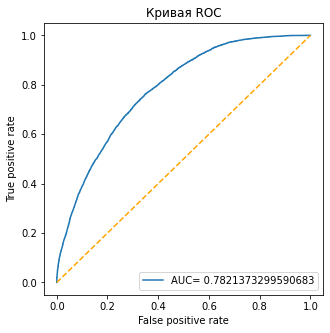

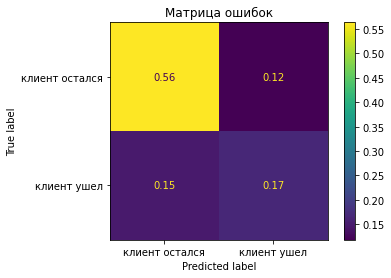

,accuracy,precision,recall,roc_auc,f1
rand_forest,0.73,0.59,0.53,0.78,0.56


In [84]:
model_key(X_res, y_res, x_test, y_test, rand_forest_best, 'rand_forest')

- Истинно отрицательные ответы TN = 0.56 (клиент остался), истинно положительные ответы (клиент ушел) TР = 0.17.
- Ложно отрицательных предсказаний больше ложно положительных: 0.15 и 0.12, соответственно.

Модель разделяет классы, но класс клиент ушел определяет гораздо хуже, чем клиент остался.

- Кривая ROC расположена выше кривой случайных ответов. Значение AUC = 0.78

- f1 = 0.56
- accuracy = 0.73
- precision = 0.59
- recall = 0.53

При использование GridSearchCV можно будет подобрать более подходящие гиперпараметры и улучшить характеристикии модели

### Оценка прибыли, которую принесёт выбранная модель

In [85]:
prediction = rand_forest_best.predict(x_test)
series = pd.Series(prediction).to_frame()
series.columns = ['prediction']
income_data = income_data.merge(series, how='left', left_index=True, right_index=True)

In [86]:
income_data.head()

,is_canceled,arrival_date_month,reserved_room_type,total_nights,factor,night_price,service_price,total_profit,prediction
0,1,January,A,1,1.00,1000,400,"-1,400.00",1
1,1,January,A,4,1.00,1000,400,"-1,400.00",0
2,1,January,A,4,1.00,1000,400,"-1,400.00",1
3,1,January,A,7,1.00,1000,400,"-1,400.00",1
4,1,January,A,7,1.00,1000,400,"-1,400.00",0


In [87]:
def pred_income(data):
    if data['is_canceled'] == 0:
        income = data['night_price'] * data['factor'] * data['total_nights']
        spenses = data['service_price'] * (1 + data['total_nights'] // 2)
    elif (data['is_canceled'] == 1) and (data['prediction'] == 0):
        income = 0
        spenses = data['service_price'] + (data['night_price'] * data['factor'])
    elif (data['is_canceled'] == 1) and (data['prediction'] == 1):
        income = (data['night_price'] * data['factor'] * .8) + (data['service_price'] * .8)
        spenses = data['service_price'] + (data['night_price'] * data['factor'])
    profit = income - spenses
    return profit

In [88]:
income_data['profit'] = income_data.apply(pred_income, axis=1)

In [89]:
income_data.head()

,is_canceled,arrival_date_month,reserved_room_type,total_nights,factor,night_price,service_price,total_profit,prediction,profit
0,1,January,A,1,1.00,1000,400,"-1,400.00",1,-280.00
1,1,January,A,4,1.00,1000,400,"-1,400.00",0,"-1,400.00"
2,1,January,A,4,1.00,1000,400,"-1,400.00",1,-280.00
3,1,January,A,7,1.00,1000,400,"-1,400.00",1,-280.00
4,1,January,A,7,1.00,1000,400,"-1,400.00",0,"-1,400.00"


In [90]:
print('Прибыль после обучения модели:', round(income_data['profit'].sum()/1000000,2), 'млн.руб')
print('Прибыль от использования модели:', round((income_data['profit'].sum() - income_data['total_profit'].sum() )/1000000, 2), 'млн.руб')

Прибыль после обучения модели: 36.77 млн.руб
Прибыль от использования модели: 4.47 млн.руб


Гипотеза по внедрению модели RandForestClassifier:

- Н0: Средняя прибыль не изменилась
- Н1: Средняя прибыль увеличилась

In [91]:
alpha = .05
results = st.ttest_ind(income_data['total_profit'], income_data['profit'])
print('p-значение:', results.pvalue / 2) 
if (results.pvalue / 2) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Принимаем нулевую гипотезу')

p-значение: 2.483703643101442e-19
Отвергаем нулевую гипотезу


Прибыль от использования модели увеличится на 4.47 млн.руб за 8 месяцев

### Вывод о разработке модели

Для проекта выбраны три модели машинного обучения:

- DecisionTreeClassifier
- RandomForestClassifier
- LogisticRegression

Также использованы две техникии балансировки классов undersampling и oversampling:

- Недостаточная выборка с использованием Tomek links (undersampling)
- SMOTETomek - Комбинация over- and under-sampling.

Лучшая модель - RandomForestClassifier с гиперпараметрами:

- random_state=12345,
- n_estimators = 251,
- max_depth = 20,
- class_weight = 'balanced_subsample'

- С использованием балансировки классов SMOTETomek from imblearn.over_sampling

- Истинно отрицательные ответы TN = 0.56 (клиент остался), истинно положительные ответы (клиент ушел) TР = 0.17.
- Ложно отрицательных предсказаний больше ложно положительных: 0.15 и 0.12, соответственно.

Модель разделяет классы, но класс клиент ушел определяет гораздо хуже, чем клиент остался.

- Кривая ROC расположена выше кривой случайных ответов. Значение AUC = 0.78

- f1 = 0.56
- accuracy = 0.73
- precision = 0.59
- recall = 0.53

При использование GridSearchCV можно будет подобрать более подходящие гиперпараметры и улучшить характеристикии модели

**Прибыль от использования модели увеличится на 4.47 млн.руб за 8 месяцев**

## Опишите портрет «ненадёжного» клиента

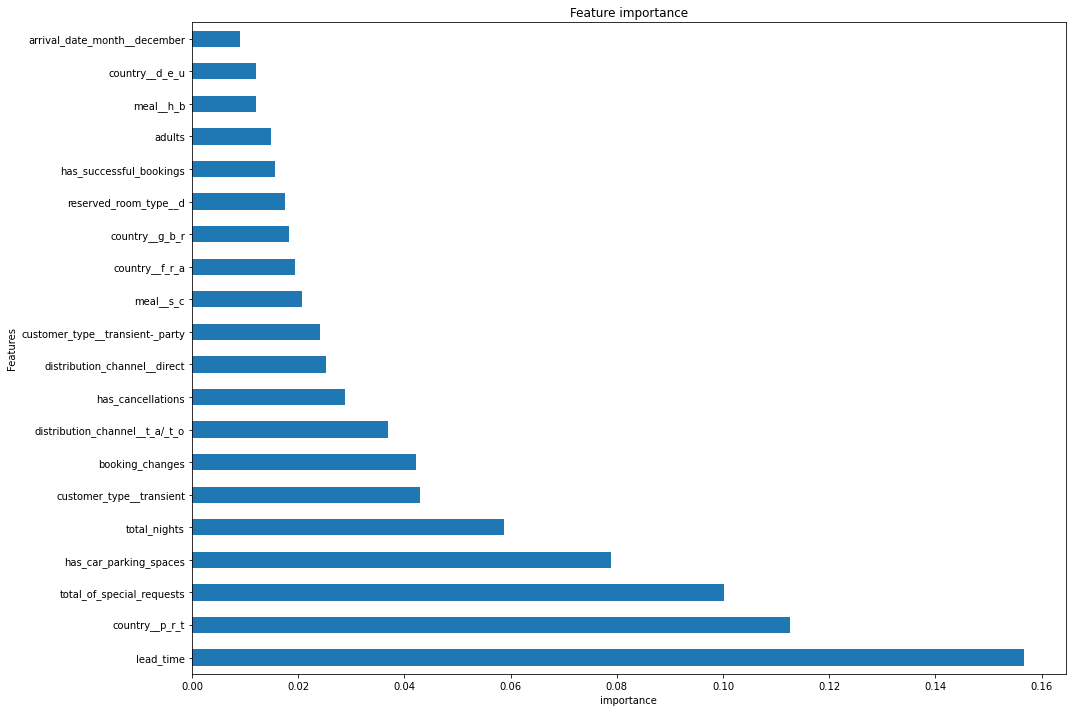

In [92]:
fig = plt.figure(figsize=(15, 10))
pd.Series(rand_forest_best.feature_importances_, x_train.columns).nlargest(20).plot(kind='barh')
plt.title('Feature importance')
plt.xlabel('importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

Модель в первую очередь оценивает такие характеристики как:

- количество дней между датой бронирования и датой прибытия
- количество специальных отметок
- требования к парковочным местам
- общее количество ночей
- факт отменённых раннее заказов у клиента

Ненадежный клиент бронирует номер сильно заранее

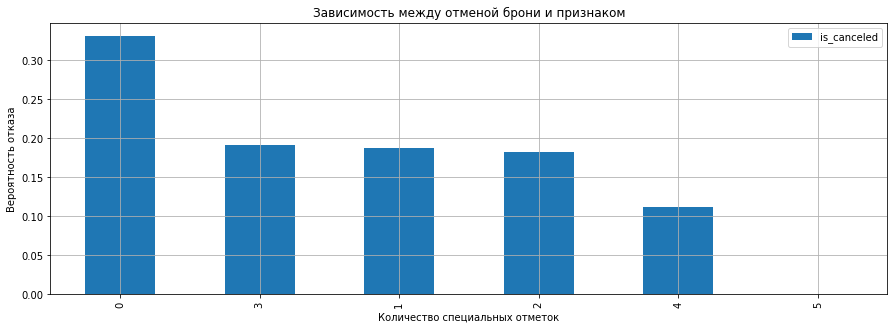

In [94]:
hotel_train[['total_of_special_requests', 'is_canceled']].groupby('total_of_special_requests').agg('mean').sort_values(by='is_canceled', ascending=False) .plot(title='Зависимость между отменой брони и признаком', kind='bar',figsize=(15,5))
plt.xlabel('Количество специальных отметок')
plt.ylabel('Вероятность отказа')
plt.grid()
#plt.xticks(rotation=45)
plt.show()

Ненадежный клиент не оставляет специальных отметок

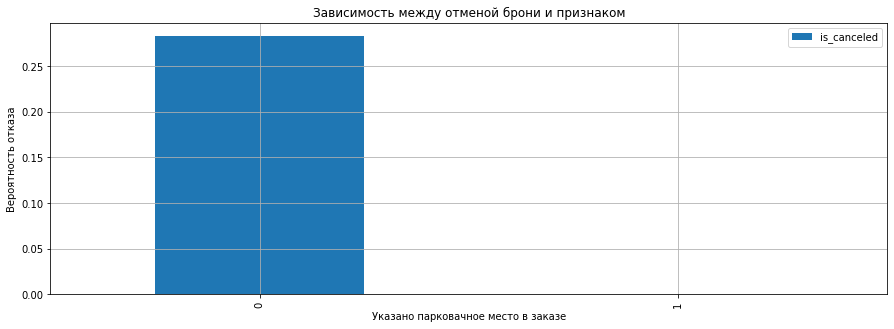

In [109]:
hotel_train[['has_car_parking_spaces', 'is_canceled']].groupby('has_car_parking_spaces').agg('mean').sort_values(by='is_canceled', ascending=False) .plot(title='Зависимость между отменой брони и признаком', kind='bar',figsize=(15,5))
plt.xlabel('Указано парковачное место в заказе')
plt.ylabel('Вероятность отказа')
plt.grid()
#plt.xticks(rotation=45)
plt.show()

Ненадежный клиент не резервирует парковочные места

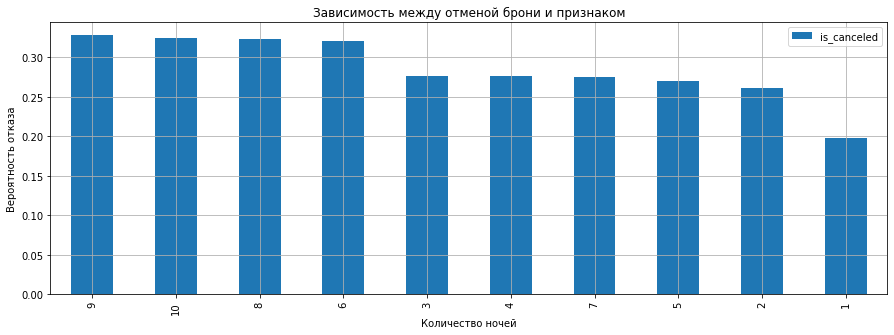

In [110]:
hotel_train[['total_nights', 'is_canceled']].groupby('total_nights').agg('mean').sort_values(by='is_canceled', ascending=False) .plot(title='Зависимость между отменой брони и признаком', kind='bar',figsize=(15,5))
plt.xlabel('Количество ночей')
plt.ylabel('Вероятность отказа')
plt.grid()
#plt.xticks(rotation=45)
plt.show()

Чем дольше планирует остаться клиент в отеле, тем больше вероятность, что он откажется от брони

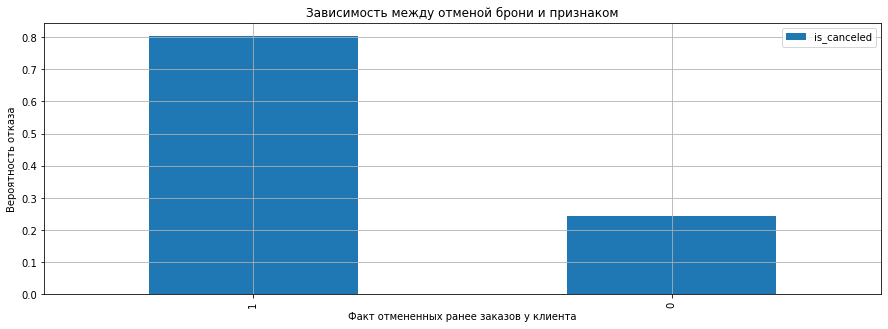

In [113]:
hotel_train[['has_cancellations', 'is_canceled']].groupby('has_cancellations').agg('mean').sort_values(by='is_canceled', ascending=False) .plot(title='Зависимость между отменой брони и признаком', kind='bar',figsize=(15,5))
plt.xlabel('Факт отмененных ранее заказов у клиента')
plt.ylabel('Вероятность отказа')
plt.grid()
#plt.xticks(rotation=45)
plt.show()

Ненадежный клиент часто отказывался от брони раньше

### Вывод по характеристикам ненадежного клиента

Ненадежный клиент: 

- Бронирует номер сильно заранее
- Не оставляет специальных отметок
- Не резервирует парковочные места
- Чем дольше планиркет остаться в отеле, тем больше вероятность, что он откажется от брони
- Часто отказывался от брони раньше

## Общий вывод

1.
- Пропущенных значений в данных нет. Дубликатов в таблиц нет. 
- В столбцах 'is_canceled' и 'is_repeated_guest' изменен тип данных на bool. 
- В столбцах  'adults', 'children', 'babies' тип данных выбран неверно: вместо float изменен на integer.
- Размеры таблиц 'hotel_train' и 'hotel_test' делятся в соотношении примерно 2:1

- В двух таблицах есть бронирования без взрослых, некоторые из них даже с детьми. Причем, не все из этих бронирований были отменены. Так что эти строки были удалены.
 
- При удалении id появилось много дублирующихся столбцов, удалены.
- Удалены из 'hotel_train' значения в столбце babies с количеством детей 9 и 10, так как их всего по одному и это напоминает аномалию, возможно это приведет к тому, что модель машинного обучения будет некорректно предсказывать отказ от брони. Вариантов с детьми больше двух тоже очень мало, так что удалены и они. Признак переименован в has_babies, чтобы обозначить его теперь уже бинарную природу. Аналогичным образом обработан и признак с количеством парковочных мест
- по той же причине удалены строки в столбце required_car_parking_spaces со значением больше 2. 
- В стобце meal есть неявный дубликат в опции SC, из-за лишних пробелов в данном столбце, аналогичные лишние пробелы есть и в столбце reserved_room_type. 
- Типы данных выбранных столбцов успешно изменены. 
- Судя по описанию, должна быть связь между тремя признаками: previous_cancellations, is_repeated_guest и previous_bookings_not_canceled: если клиент бронирует номер не в первый раз, то у него должны быть либо отмененные заказы, либо подтвержденные. Эти условия не соблюдаются, поэтому добавлены вместо них два новых бинарных признака: has_cancellations и has_successful_bookings.

- Использовалось OHE кодирование категориальных признаков и StandardScaler для численных признаков для будущих моделей.

- Целевой признак несбалансирован. В таблице hotel_train процент отказа от брони составляет 25.4%, в hotel_test - 31.5%. В дальнейшем будет применена балансировка классов. 

- В основном, бронирование номеров происходит летом, дальше идут весенние и осенние месяцы, традиционный спад в январе из-за новогодних праздников. Ценовая политика отеля с использованием сезонных коэффициенты (весной и осенью цены повышаются на 20%, летом — на 40%) - рациональна.

2. Создана таблица с ключевыми бизнес-метриками, разработана функция для расчета прибыли отеля
- Прибыль с января по август 2017 г. без внедрения депозита составила 32.6 млн.руб.

3. Для проекта выбраны три модели машинного обучения:

- DecisionTreeClassifier
- RandomForestClassifier
- LogisticRegression

Также использованы две техникии балансировки классов undersampling и oversampling:

- Недостаточная выборка с использованием Tomek links (undersampling)
- SMOTETomek - Комбинация over- and under-sampling.

Лучшая модель - RandomForestClassifier с гиперпараметрами:

- random_state=12345,
- n_estimators = 251,
- max_depth = 20,
- class_weight = 'balanced_subsample'

- С использованием балансировки классов SMOTETomek from imblearn.over_sampling

- Истинно отрицательные ответы TN = 0.56 (клиент остался), истинно положительные ответы (клиент ушел) TР = 0.17.
- Ложно отрицательных предсказаний больше ложно положительных: 0.15 и 0.12, соответственно.

Модель разделяет классы, но класс клиент ушел определяет гораздо хуже, чем клиент остался.

- Кривая ROC расположена выше кривой случайных ответов. Значение AUC = 0.78

- f1 = 0.56
- accuracy = 0.73
- precision = 0.59
- recall = 0.53

При использование GridSearchCV можно будет подобрать более подходящие гиперпараметры и улучшить характеристикии модели

**Прибыль после обучения моделисоставила 36.77 млн.руб. Прибыль от использования модели увеличится на 4.47 млн.руб за 8 месяцев**

4. Ненадежный клиент: 

- Бронирует номер сильно заранее
- Не оставляет специальных отметок
- Не резервирует парковочные места
- Чем дольше планирует остаться в отеле, тем больше вероятность, что он откажется от брони
- Часто отказывался от брони раньше